# Introduction

<center><h3>**Welcome to the Language modeling Notebook.**</h3></center>

In this assignment, you are going to train a neural network to **generate news headlines**.
To reduce computational needs, we have reduced it to headlines about technology, and a handful of Tech giants.
In this assignment you will:
- Learn to preprocess raw text so it can be fed into an LSTM.
- Make use of the LSTM library of Tensorflow, to train a Language model to generate headlines
- Use your network to generate headlines, and judge which headlines are likely or not




**What is a language model?**

Language modeling is the task of assigning a probability to sentences in a language. Besides assigning a probability to each sequence of words, the language models also assigns a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words.
— Page 105, __[Neural Network Methods in Natural Language Processing](https://www.amazon.com/Language-Processing-Synthesis-Lectures-Technologies/dp/1627052984/)__, 2017.

In terms of neural network, we are training a neural network to produce probabilities (classification) over a fixed vocabulary of words.
Concretely, we are training a neural network to produce:
$$ P ( w_{i+1} | w_1, w_2, w_3, ..., w_i), \forall i \in (1,n)$$

** Why is language modeling important? **

Language modeling is a core problem in NLP.

Language models can either be used as a stand-alone to produce new text that matches the distribution of text the model is trained on, but can also be used at the front-end of a more sophisticated model to produce better results.

Recently for example, the __[BERT](https://arxiv.org/abs/1810.04805)__ paper show-cased that pretraining a large neural network on a language modeling task can help improve state-of-the-art on many NLP tasks. 

How good can the generation of a Language model be?

If you have not seen the latest post by OpenAI, you should read some of the samples they generated from their language model __[here](https://blog.openai.com/better-language-models/#sample1)__.
Because of computational restrictions, we will not achieve as good text production, but the same algorithm is at the core. They just use more data and compute.

# Library imports

Before starting, make sure you have all these libraries.

In [1]:
!pip install segtok

In [2]:
# Getting access to the dataset and the Python files on Google Drive.
# You will probably have to give permission.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### "upload" requirements_gpu file into collab session

In [0]:
from segtok import tokenizer
from collections import Counter
import tensorflow as tf
import numpy as np
import json
import os, sys

sys.path.insert(0, "/content/gdrive/My Drive/CS 182/assignment3/") # This enables us to import Python libraries in the folder.

root_folder = "/content/gdrive/My Drive/CS 182/assignment3/"

# Preprocessing

**You can skip this section, however you may find these functions useful later in the assignment**

We have provided this code so you see how the dataset was generated. You will have to come back some of these functions later in the assignment, so feel free to read through, to get familiar.

In [0]:
def numerize_sequence(tokenized):
    return [w2i.get(w, unkI) for w in tokenized]
def pad_sequence(numerized, pad_index, to_length):
    pad = numerized[:to_length]
    padded = pad + [pad_index] * (to_length - len(pad))
    mask = [w != pad_index for w in padded]
    return padded, mask

In [0]:
# You do not need to run this
# This is to show you how the dataset was created
# You should read to understand, so you can preprocess text
# In the same way, in the evaluation section

for a in dataset:
    a['tokenized'] = tokenizer.word_tokenizer(a['title'].lower())

In [0]:
# You do not need to run this
# This is to show you how the dataset was created
# You should read to understand, so you can preprocess text
# In the same way, in the evaluation section

word_counts = Counter()
for a in dataset:
    word_counts.update(a['tokenized'])

print(word_counts.most_common(30))

NameError: ignored

In [60]:
# You do not need to run this
# This is to show you how the dataset was created
# You should read to understand, so you can preprocess text
# In the same way, in the evaluation section

# Creating the vocab
vocab_size = 20000
special_words = ["<START>", "UNK", "PAD"]
vocabulary = special_words + [w for w, c in word_counts.most_common(vocab_size-len(special_words))]
w2i = {w: i for i, w in enumerate(vocabulary)}

# Numerizing and padding
input_length = 20
unkI, padI, startI = w2i['UNK'], w2i['PAD'], w2i['<START>']

for a in dataset:
    a['numerized'] = numerize_sequence(a['tokenized']) # Change words to IDs
    a['numerized'], a['mask'] = pad_sequence(a['numerized'], padI, input_length) # Append appropriate PAD tokens
    
# Compute fraction of words that are UNK:
word_counters = Counter([w for a in dataset for w in a['input'] if w != padI])

print("Fraction of UNK words:", float(word_counters[unkI]) / sum(word_counters.values()))

NameError: ignored

In [0]:
# You do not need to run this
# This is to show you how the dataset was created
# You should read to understand, so you can preprocess text
# In the same way, in the evaluation section

d_released_processed   = [d for d in dataset if d['cut'] != 'testing']
d_unreleased_processed = [d for d in dataset if d['cut'] == 'testing']

with open("dataset/headline_generation_dataset_processed.json", "w") as f:
    json.dump(d_released_processed, f)

# This file is purposefully left out of the assignment, we will use it to evaluate your model.
with open("dataset/headline_generation_dataset_unreleased_processed.json", "w") as f:
    json.dump(d_unreleased_processed, f)
    
with open("dataset/headline_generation_vocabulary.txt", "w") as f:
    f.write("\n".join(vocabulary).encode('utf8'))

# Loading the datasets

Make sure the dataset files are all in the `dataset` folder of the assignment.

 - If you are using this notebook locally: You should run the `download_data.sh` script.
 - If you are using the Colab version of the notebook, make sure that your Google Drive is mounted, and you verify from the file explorer in Colab that the files are viewable within `/content/gdrive/CS182_HW03/dataset/`
 


In [8]:
# This cell loads the data for the model
# Run this before working on loading any of the additional data

with open(root_folder+"dataset/headline_generation_dataset_processed.json", "r") as f:
    d_released = json.load(f)

with open(root_folder+"dataset/headline_generation_vocabulary.txt", "r") as f:
    vocabulary = f.read().split("\n")
w2i = {w: i for i, w in enumerate(vocabulary)} # Word to index
unkI, padI, start_index = w2i['UNK'], w2i['PAD'], w2i['<START>']

vocab_size = len(vocabulary)
input_length = len(d_released[0]['numerized']) # The length of the first element in the dataset, they are all of the same length
d_train = [d for d in d_released if d['cut'] == 'training']
d_valid = [d for d in d_released if d['cut'] == 'validation']

print("Number of training samples:",len(d_train))
print("Number of validation samples:",len(d_valid))

Number of training samples: 88568
Number of validation samples: 946


Now that we have loaded the data, let's inspect one of the elements. Each sample in our dataset is has a `numerized` vector, that contains the preprocessed headline. This vector is what we will feed in to the neural network. The field `numerized` corresponds to this list of tokens. The already loaded dictionary `vocabulary` maps token lists to the actual string. Use these elements to recover `title` key of entry 1001 in the training dataset.

**TODO**: Write the numerized2text function and inspect element 1001 in the training dataset (`entry = d_train[1001]`).



In [9]:
def numerized2text(numerized):
    """ Converts an integer sequence in the vocabulary into a string corresponding to the title.
    
        Arguments:
            numerized: List[int]  -- The list of vocabulary indices corresponding to the string
        Returns:
            title: str -- The string corresponding to the numerized input, without padding.
    """
    #####
    # BEGIN YOUR CODE HERE 
    # Recover each word from the vocabulary in the list of indices in numerized, using the vocabulary variable
    # Hint: Use the string.join() function to reconstruct a single string
    #####
    
    words = [vocabulary[i] for i in numerized]
    converted_string = ' '.join(words)
    
    #####
    # END YOUR CODE HERE
    #####
    
    return converted_string

entry = d_train[1001]
print("Reversing the numerized: "+numerized2text(entry['numerized']))
print("From the `title` entry: "+ entry['title'])

Reversing the numerized: microsoft donates cloud computing ' worth $ 1 bn ' PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
From the `title` entry: Microsoft donates cloud computing 'worth $1 bn'


In language modeling, we train a model to produce the next word in the sequence given all previously generated words. This has, in practice, two steps:


    1. Adding a special <START> token to the start of the sequence for the input. This "shifts" the input to the right by one. We call this the "source" sequence
    2. Making the network predict the original, unshifted version (we call this the "target" sequence)

    
Let's take an example. Say we want to train the network on the sentence: "The cat is great."
The input to the network will be "`<START>` The cat is great." The target will be: "The cat is great".
    
Therefore the first prediction is to select the word "The" given the `<START>` token.
The second prediction is to produce the word "cat" given the two tokens "`<START>` The".
At each step, the network learns to predict the next word, given all previous ones.
    
---

Your next step is to write the build_batch function. Given a dataset, we select a random subset of samples, and will build the "inputs" and the "targets" of the batch, following the procedure we've described.

**TODO**: write the build_batch function. We give you the structure, and you have to fill in where we have left things `None`.


In [0]:
def build_batch(dataset, batch_size):
    """ Builds a batch of source and target elements from the dataset.
    
        Arguments:
            dataset: List[db_element] -- A list of dataset elements
            batch_size: int -- The size of the batch that should be created
        Returns:
            batch_input: List[List[int]] -- List of source sequences
            batch_target: List[List[int]] -- List of target sequences
            batch_target_mask: List[List[int]] -- List of target batch masks
    """
    
    #####
    # BEGIN YOUR CODE HERE 
    #####
    
    
    # We get a list of indices we will choose from the dataset.
    # The randint function uses a uniform distribution, giving equal probability to any entry
    # for each batch
    indices = list(np.random.randint(0, len(dataset), size=batch_size))
    
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    
    # Get the raw numerized for this input, each element of the dataset has a 'numerized' key
    batch_numerized = [element['numerized'] for element in batch]

    # Create an array of start_index that will be concatenated at position 1 for the input.
    # Should be of shape (batch_size, 1)
    start_tokens = np.reshape([start_index]*batch_size, (batch_size,1))

    # Concatenate the start_tokens with the rest of the input
    # The np.concatenate function should be useful
    # The output should now be [batch_size, sequence_length+1]
    batch_input = np.concatenate((start_tokens,batch_numerized),axis=1)

    # Remove the last word from each element in the batch
    # To restore the [batch_size, sequence_length] size
    batch_input = batch_input[:, :-1]
    
    # The target should be the un-shifted numerized input
    batch_target = batch_numerized

    # The target-mask is a 0 or 1 filter to note which tokens are
    # padding or not, to give the loss, so the model doesn't get rewarded for
    # predicting PAD tokens.
    batch_target_mask = np.array([a['mask'] for a in batch])
    
    #####
    # END YOUR CODE HERE 
    #####
        
    return batch_input, batch_target, batch_target_mask

# Creating the language model

Now that we've written the data pipelining, we are ready to write the Neural network.

The steps to setting up a neural network to do Language modeling are:
- Creating the placeholders for the model, where we can feed in our inputs and targets.
- Creating an RNN of our choice, size, and with optional parameters
- Using the RNN on our placeholder inputs.
- Getting the output from the RNN, and projecting it into a vocabulary sized dimension, so that we can make word predictions.
- Setting up the loss on the outputs so that the network learns to produce the correct words.
- Finally, choosing an optimizer, and defining a training operation: using the optimizer to minimize the loss.

We provide skeleton code for the model, you can fill in the `None` section. If you are unfamiliar with Tensorflow, we provide some idea of what functions to look for, you should use the Tensorflow online documentation.

**TODO**: Replace the `None` variables with their respective code elements in the LanguageModel Class


In [0]:
# Using a basic RNN/LSTM for Language modeling
class LanguageModel():
    def __init__(self, input_length, vocab_size, rnn_size, learning_rate=1e-4):
        
        # Create the placeholders for the inputs:
        # All three placeholders should be of size [None, input_length]
        # Where None represents a variable batch_size, and input_length is the
        # maximal length of a sequence of words, after being padded.
        self.input_num = tf.placeholder(tf.int32, shape=[None, input_length])
        self.targets = tf.placeholder(tf.int32, shape=[None, input_length])
        self.targets_mask = tf.placeholder(tf.int32, shape=[None, input_length])

        # Create an embedding variable of shape [vocab_size, rnn_size]
        # That will map each word in our vocab into a vector of rnn_size size.
        embedding = tf.get_variable('word_embeddings', [vocab_size, input_length])
        # Use the tensorflow embedding_lookup function
        # To embed the input_num, using the embedding variable we've created
        input_emb = tf.nn.embedding_lookup(embedding, self.input_num)

        # Create a an RNN or LSTM cell of rnn_size size.
        # Look into the tf.nn.rnn_cell documentation
        # You can optionally use Tensorflow Add-ons such as the MultiRNNCell, or the DropoutWrapper
        num_units = [512, 256, 128, 64, 32]
        cells = [tf.nn.rnn_cell.LSTMCell(num_units=n) for n in num_units]
        lm_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
        lm_cell = tf.nn.rnn_cell.LSTMCell(rnn_size)
        input_keep_prob = tf.placeholder_with_default(tf.constant(1.0, dtype=tf.float32), ())
        lm_cell = tf.nn.rnn_cell.DropoutWrapper(lm_cell,input_keep_prob=input_keep_prob)
        
        # Use the dynamic_rnn function of Tensorflow to run the embedded inputs
        # using the lm_cell you've created, and obtain the outputs of the RNN cell.
        # You have created a cell, which represents a single block (column) of the RNN.
        # dynamic_rnn will "copy" the cell for each element in your sequence, runs the input you provide through the cell,
        # and returns the outputs and the states of the cell.
        outputs, states = tf.nn.dynamic_rnn(lm_cell, 
                                            input_emb,
                                            initial_state=lm_cell.zero_state(tf.shape(self.input_num)[0], dtype=tf.float32),
                                            dtype=tf.float32)

        # Use a dense layer to project the outputs of the RNN cell into the size of the
        # vocabulary (vocab_size).
        # output_logits should be of shape [None,input_length,vocab_size]
        # You can look at the tf.layers.dense function
        self.output_logits = tf.layers.dense(outputs,units=vocab_size)

        # Setup the loss: using the sparse_softmax_cross_entropy.
        # The logits are the output_logits we've computed.
        # The targets are the gold labels we are trying to match
        # Don't forget to use the targets_mask we have, so your loss is not off,
        # And your model doesn't get rewarded for predicting PAD tokens
        # You might have to cast the masks into float32. Look at the tf.cast function.
        self.loss = tf.losses.sparse_softmax_cross_entropy(self.targets,
                                                           self.output_logits,
                                                           weights=tf.cast(self.targets_mask, tf.float32))
        
        # Setup an optimizer (SGD, RMSProp, Adam), you can find a list under tf.train.*
        # And provide it with a start learning rate.
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.1
        optimizer = tf.train.AdamOptimizer(tf.train.exponential_decay(starter_learning_rate, global_step,
                                           50000, 0.96, staircase=True))      

        # We create a train_op that requires the optimizer we've created to minimize the
        # loss we've defined.
        # look for the optimizer.minimize function, define what should be miniminzed.
        # You can provide it with the provide an optional global_step parameter as well that keeps of how many
        # Optimizations steps have been run.
        
        self.global_step = tf.train.get_or_create_global_step()
        self.train_op = optimizer.minimize(self.loss)  
        self.saver = tf.train.Saver()

Once you have created the Model class, we should instantiate the model. The line tf.reset_default_graph() resets the graph for the Jupyter notebook, so multiple models aren't floating around. If you have trouble with redefinition of variables, it may be worth re-running the cell below. 

In [12]:
# We can create our model,
# with parameters of our choosing.

tf.reset_default_graph() # This is so that when you debug, you reset the graph each time you run this, in essence, cleaning the board
model = LanguageModel(input_length=input_length, vocab_size=vocab_size, rnn_size=256, learning_rate=1e-4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


# Training the model

Your objective is to train the Language on the dataset you are provided to reach a **loss <= 5.50**

**TODO**: Train your model so that it achieves a loss of <= 5.5. 

**Careful**: we will be testing this loss on an unreleased test set, so make sure to evaluate properly on a validation set and not overfit. You must save the model you want us to test under: models/final_language_model (the .index, .meta and .data files)

**Advice**:
- It should be possible to attain loss <= 5.50 with a 1-layer LSTM of size 256 or less.
- You should not need more than 10 epochs to attain the threshold. More passes over the data can however give you a better model.
- You can however try using:
    - LSTM dropout (Tensorflow has a layer for that)
    - Multi-layer RNN cell (Tensorflow has a layer for that)
    - Change your optimizers, tune your learning_rate, use a learning rate schedule.
    
**Extra credit**:

Get the loss below **loss <= 5.00** and get 5 points of extra-credit on this assignment. Get creative,
but remember, what you do should work on our held-out test set to get the points.

In [23]:
import matplotlib.pyplot as plt
import time
experiment = root_folder+"models/final_language_model"
epochs = 20
batch_size = 4
num_batches = (len(d_train)//(2**batch_size))
print("num_batches",num_batches)
val_losses = []
train_losses = []

num_batches 5535


In [0]:
# We will evaluate your model in the model_file above
# In a very similar way as the code below.
# Make sure your validation loss is befow the threshold we specified
# and that you didn't train using the validation set, as you would
# get penalized.

# Your best performing model should go here.
model_file = root_folder+"models/final_language_model"

def val_loss():
  with tf.Session() as sess:
      model.saver.restore(sess, model_file)
      eval_input, eval_target, eval_target_mask = build_batch(d_valid, 500)
      feed = {model.input_num: eval_input, model.targets: eval_target, model.targets_mask: eval_target_mask}
      eval_loss = sess.run([model.loss], feed_dict=feed)
      return eval_loss[0]

In [26]:
# Skeleton code
# You have to write your own training process to obtain a
# Good performing model on the validation set, and save it.

with tf.Session() as sess:
    input_keep_prob = tf.placeholder_with_default(tf.constant(1.0, dtype=tf.float32), ())
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
      batches = [(build_batch(d_train, 2**batch_size)) for _ in range(num_batches)]
      batch_num = 0
      epoch_loss = 0
      for batch_input, batch_target, batch_target_mask in batches:

        # Map the values to each tensor in a `feed_dict`
        feed = {model.input_num: batch_input, model.targets: batch_target, model.targets_mask: batch_target_mask, input_keep_prob: 0.6}

        # Obtain a single value of the loss for that batch.
        # !IMPORTANT! Don't forget to include the train_op to when using a batch from the training dataset
        # (d_train)
        # !MORE IMPORTANT! Don't use the train_op if you evaluate the loss on the validation set,
        # Otherwise, your network will overfit on your validation dataset.

        step, batch_loss, _ = sess.run([model.global_step, model.loss, model.train_op], feed_dict=feed)
        epoch_loss += batch_loss/num_batches
        print("\rfinished batch "+str(batch_num)+"/"+str(num_batches)+", current epoch loss: " + str(epoch_loss),end="")
        batch_num += 1
      
      train_losses.append(epoch_loss)
      
      # Here is how you save the model weights
      model.saver.save(sess, experiment)
      
      # Here is how you restore the weights previously saved
      model.saver.restore(sess, experiment)
      
      epoch_vl = val_loss()
      val_losses.append(epoch_vl)
      print ("Training & validation loss after epoch %i: %f, %f" % (epoch, epoch_loss, epoch_vl))

      if ((epoch+1) % 4) == 0 and batch_size < 9:
        batch_size += 1
        num_batches = (len(d_train)//(2**batch_size))
        print("increasing batch_size next epoch to: "+str(2**batch_size))

finished batch 5534/5535, current epoch loss: 7.140312286573375INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CS 182/assignment3/models/final_language_model
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CS 182/assignment3/models/final_language_model
Training & validation loss after epoch 0: 7.140312, 7.102096
finished batch 5534/5535, current epoch loss: 7.198346276873378INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CS 182/assignment3/models/final_language_model
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CS 182/assignment3/models/final_language_model
Training & validation loss after epoch 1: 7.198346, 7.240831
finished batch 5534/5535, current epoch loss: 7.161825425579636INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CS 182/assignment3/models/final_language_model
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CS 182/assignment3/models/final_language_model
Train

20 20 20


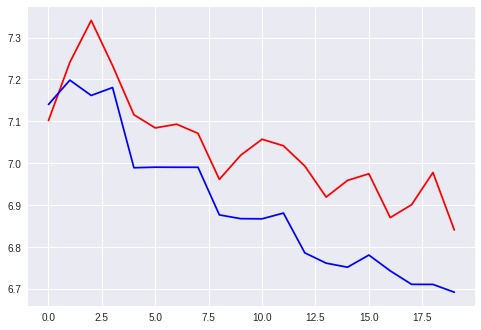

In [28]:
fig, ax = plt.subplots()
epocs_x = [i for i in range(epochs)]
ax.plot(epocs_x,val_losses,color="red")
ax.plot(epocs_x,train_losses,color="blue")
fig.canvas.draw()
print(len(epocs_x),len(val_losses),len(train_losses))

# Using the language model

Congratulations, you have now trained a language model! We can now use it to evaluate likely news headlines, as well as generate our very own headlines.

**TODO**: Complete the three parts below, using the model you have trained.

## (1) Evaluation loss

To evaluate the language model, we evaluate its loss (ability to predict) on unseen data that is reserved for evaluation.
Your first evaluation is to load the model you trained, and obtain a test loss.

In [29]:
print("average validation loss:",np.mean(val_losses))

average validation loss: 7.0399704


## (2) Evaluation of likelihood of data

One use of a language model is to see what data is more likely to have originated from the training data. Because we have trained our model on news headlines, we can see which of these headlines is more likely:

``Apple to release another iPhone in September``


 ``Apple and Samsung resolve all lawsuits amicably``
 
**TODO**: Use the model to obtain the loss the neural network assigns to each sentence.
Because the neural network assigns probability to the words appearing in a sequence, this loss can be used as a proxy to measure how likely the sentence is to have occurred in the dataset.
Once you have the loss for each headline, write down which sentence was judged to be more likely, and explain why/if you think this is coherent.

**Your answer:**


In [58]:
headline1 = "Apple to release new iPhone in July"
headline2 = "Apple and Samsung resolve all lawsuits"

headlines = [headline1, headline2]

with tf.Session() as sess:
    model.saver.restore(sess, model_file)

    for headline in headlines:
        headline = headline.lower() # Our LSTM is trained on lower-cased headlines
    
        # From the code in the Preprocessing section of the notebook
        # Find out how to tokenize the headline
        tokenized = tokenizer.word_tokenizer(headline)
        
        # Find out how to numerize the tokenized headline
        numerized = [w2i['<START>']]+numerize_sequence(tokenized)

        # Learn how to pad and obtain the mask of the sequence.
        padded, mask = pad_sequence(numerized, padI, input_length)
        print(len(padded),len(mask))
        # Obtain the loss of the sequence, and print it
        #{model.input_num: eval_input, model.targets: eval_target, model.targets_mask: eval_target_mask}
        loss = sess.run(model.loss, feed_dict={
            model.input_num: np.array(padded).reshape((1,20)), 
            model.targets: np.array(padded).reshape((1,20)),
            model.targets_mask: np.array(mask).reshape((1,20))
        })
        print("----------------------------------------")
        print("Headline:",headline)
        print("Loss of the headline:", loss)

# Important check: one headline should be more likely (and have lower loss)
# Than the other headline. You should know which headline should have lower loss.

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CS 182/assignment3/models/final_language_model
20 20
----------------------------------------
Headline: apple to release new iphone in july
Loss of the headline: 10.75341
20 20
----------------------------------------
Headline: apple and samsung resolve all lawsuits
Loss of the headline: 12.4024


## (3) Generation of headlines

We can use our language model to generate text according to the distribution of our training data.
The way generation works is the following:

We seed the model with a beginning of sequence, and obtain the distribution for the next word.
We select the most likely word (argmax) and add it to our sequence of words.
Now our sequence is one word longer, and we can feed it in again as an input, for the network to produce the next sentence.
We do this a fixed number of times (up to 20 words), and obtain automatically generated headlines!


We have provided a few headline starters that should produce interesting generated headlines.

**TODO:** Get creative and find at least 2 more headline_starters that produce interesting headlines.

In [135]:
import random 

with tf.Session() as sess:
    model.saver.restore(sess, model_file)

    # Here are some headline starters.
    # They're all about tech companies, because
    # That is what is in our dataset
    headline_starters = ["apple has released", "google has released", "amazon", "tesla to"]
    
    for headline_starter in headline_starters:
        print("===================")
        print("Generating headline starting with: "+headline_starter)

        # Tokenize and numerize the headline. Put the numerized headline
        # beginning in `current_build`
        tokenized = tokenizer.word_tokenizer(headline_starter)
        current_build = [w2i['<START>']] + numerize_sequence(tokenized)

        while len(current_build) < input_length:
            # Pad the current_build into a input_length vector.
            # We do this so that it can be processed by our LanguageModel class
            current_padded = current_build[:input_length] + [padI] * (input_length - len(current_build))
            current_padded = np.array([current_padded])

            # Obtain the logits for the current padded sequence
            # This involves obtaining the output_logits from our model,
            # and not the loss like we have done so far
            logits = sess.run(model.output_logits, feed_dict={
                model.input_num: current_padded
            })

            # Obtain the row of logits that interest us, the logits for the last non-pad
            # inputs
            last_logits = logits[0,-1,:]
            
            # Find the highest scoring word in the last_logits
            # array. The np.argmax function should be useful.
            # Append this word to our current build
            current_build.append((np.argsort(last_logits))[-2])
        
        # Go from the current_build of word_indices
        # To the headline (string) produced. This should involve
        # the vocabulary, and a string merger.
        words = [vocabulary[i] for i in current_build]
        produced_sentence = " ".join(words[1:])
        print(produced_sentence)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/CS 182/assignment3/models/final_language_model
Generating headline starting with: apple has released
apple has released facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook
Generating headline starting with: google has released
google has released to , , , , , , , , , , , , , , ,
Generating headline starting with: amazon
amazon facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook facebook
Generating headline starting with: tesla to
tesla to to , , , , , , , , , , , , , , , ,


## All done

You are done with the first part of the HW.

Next notebook deals with Summarization of text!
